# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

В соответствии с задачей, нам необходимо составить модель предсказания рыночной стоимости автомобиля для клиентов сервиса по продаже автомобилей с пробегом "Не бит, не крашен". 

Так как рыночная стоимость (наш целевой признак) - это числовое значение, задача сводится к созданию модели регрессии.

Также будем обращать внимание на то, что помимо качества предсказания модели, заказчику важна скорость предсказания и время обучения модели.

Приступим и начнем с выгрузки необходимых для дальнейшей работы библиотек.

### Выгрузка необходимых библиотек

In [1]:
!pip install scikit-learn==1.1.3

import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

RANDOM = 12345


Библиотеки выгружены - перейдем к выгрузке и предобработке данных.

### Выгрузка и первичный анализ данных

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Как мы видим из выведенного на экран датасета - он состоит из 16 столбцов. В нашей модели будут использоваться только те столбцы, которые будут нести смысловую нагрузку для рассчета рыночной стоимости автомобиля. Поэтому, удалим следущие столбцы из датасета сразу, чтобы сэкономить время вдальнейшем:
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- RegistrationMonth — месяц регистрации автомобиля


In [3]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'RegistrationMonth', 'PostalCode', 'LastSeen'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Теперь остались только важные для задачи признаки. Продолжим изучение датасета

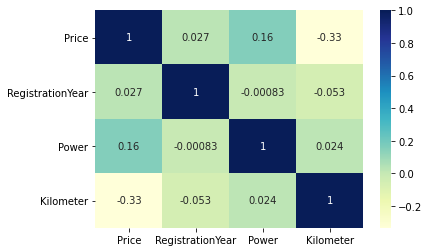

In [4]:
df_plot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)  


Мы вывели график зависимости признаков друг от друга - четкой и сильной зависимости (во избежание мультиколлинеарности) не наблюдается, как видно из графика

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 354369 entries, 0 to 354368

Data columns (total 10 columns):

 #   Column            Non-Null Count   Dtype 

---  ------            --------------   ----- 

 0   Price             354369 non-null  int64 

 1   VehicleType       316879 non-null  object

 2   RegistrationYear  354369 non-null  int64 

 3   Gearbox           334536 non-null  object

 4   Power             354369 non-null  int64 

 5   Model             334664 non-null  object

 6   Kilometer         354369 non-null  int64 

 7   FuelType          321474 non-null  object

 8   Brand             354369 non-null  object

 9   Repaired          283215 non-null  object

dtypes: int64(4), object(6)

memory usage: 27.0+ MB


Теперь наш датасет состоит из 10 столбцов и 354369 строк. Типы данных в столбцах приемлемы для дальнейшей работы. 

Но при этом в данных есть пропущенные значения в столбцах "Тип кузова автомобиля", "Тип коробки передач", "Модель автомобиля", "Тип топлива", а также "Была ли машина в ремонте" (причем в последней колонке пропусков наибольшее количество - около 71000 строк). 


### Работа с пропусками

Из 354369 срок - 71000 составляет чуть меньше четверти значений, но при этом колонка важна как признак, а пропущенные значения мы не сможем заменить ни средним, ни медианой. Поэтому для колонки "Ремонтировался ли автомобиль" предлагаю заменить пропущенные значения отметками "no" (не ремонтировался) - так как это наиболее логичное обоснование пропуска.

При этом в колонках "Модель", "Тип коробки передач", "Тип кузова", "Тип топлива" также невозможно заменить пропуски каким-то значением, либо логической заменой. Можно, конечно же, воспользоваться методом mode(), который возвращает наиболее часто встречающиеся значения, но я уверен, что в большинстве случаев мы получим что-то на  подобии "Volkswagen Golf в кузове джип на механике с дизельным топливом", что явно некорректно и для работы модели предсказаний будет критично. Поэтому, учитывая небольшое (относительно всего датасета) количество строк - удалим их. Пожертвуем количеством в целях качества.

Приступим

In [6]:
df = df.dropna(axis =0, subset=['VehicleType']).reset_index(drop=True)
df = df.dropna(axis =0, subset=['Gearbox']).reset_index(drop=True)
df = df.dropna(axis =0, subset=['Model']).reset_index(drop=True)
df = df.dropna(axis =0, subset=['FuelType']).reset_index(drop=True)

df['Repaired'] = df['Repaired'].fillna('no')

df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 284126 entries, 0 to 284125

Data columns (total 10 columns):

 #   Column            Non-Null Count   Dtype 

---  ------            --------------   ----- 

 0   Price             284126 non-null  int64 

 1   VehicleType       284126 non-null  object

 2   RegistrationYear  284126 non-null  int64 

 3   Gearbox           284126 non-null  object

 4   Power             284126 non-null  int64 

 5   Model             284126 non-null  object

 6   Kilometer         284126 non-null  int64 

 7   FuelType          284126 non-null  object

 8   Brand             284126 non-null  object

 9   Repaired          284126 non-null  object

dtypes: int64(4), object(6)

memory usage: 21.7+ MB


Мы избавились от пропусков в данных. Итого теперь наш рабочий датасет состоит из 10 столбцов и 284126 строк. Теперь проверим численные признаки на предмет аномальных значений (выбросов) и по возможности разберемся с ними.

### Проверка на аномальные значения

Методом describe() выведем на экран информацию по разбросу значений в столбцах

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,284126.000000,284126.000000,284126.000000,284126.000000
mean,4847.265516,2002.567861,117.727213,128261.651521
std,4637.056831,6.243808,169.107292,36739.971043
min,0.000000,1910.000000,0.000000,5000.000000
25%,1300.000000,1999.000000,75.000000,125000.000000
50%,3199.000000,2003.000000,109.000000,150000.000000
75%,6999.000000,2007.000000,147.000000,150000.000000
max,20000.000000,2018.000000,20000.000000,150000.000000


Итак, мы видим, что:
- столбец "Цена" содержит минимальное значение 0 (нулевая стоимость нам не нужна, а значит скорее всего это выбросы, которые необходимо будет убрать)
- столбец "Год регистрации" содержит минимальное значение 1910, а максимальное 2018 (промежуток с 1910 по 2018 года вполне реален)
- столбец "Мощность" имеет минимальное значение 0 л/с, а максимальное 20000 л/с, что не вполне реально (самым мощным автомобилем является карьерный самосвал Caterpillar 797F мощностью 4000 л/с - ограничимся им), а значит скорее всего это также выбросы
- столбец "Пробег" имеет вполне реальные значения

Приступим


Для начала построим два боксплота по столбцам "Цена" и "Мощность", чтобы посмотреть визуально на характер аномальных значений.

[Text(0.5, 1.0, 'Аномальные значения столбца "Цена"')]

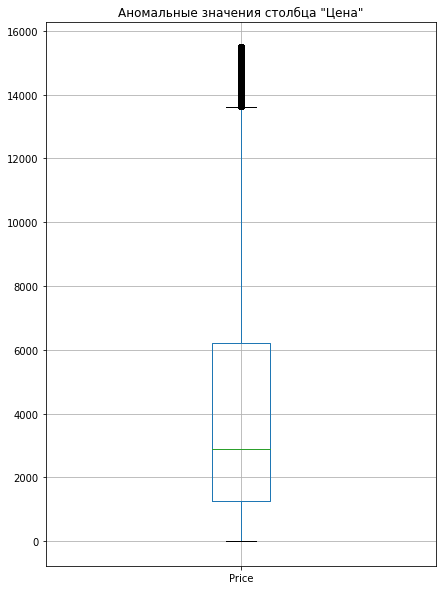

In [23]:
df.boxplot(column=['Price'], figsize = (7,10)).set(title='Аномальные значения столбца "Цена"')

[Text(0.5, 1.0, 'Аномальные значения столбца "Мощность"')]

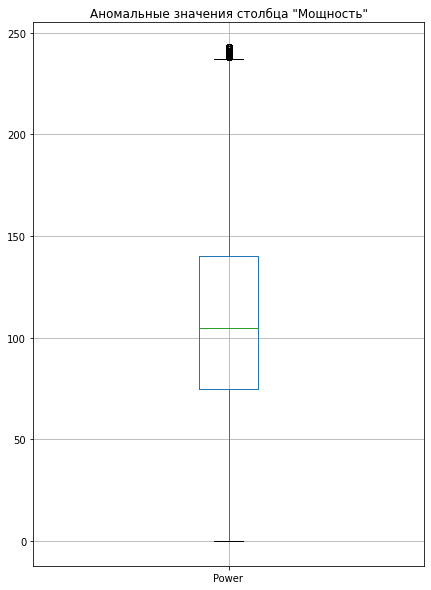

In [25]:
df.boxplot(column=['Power'], figsize = (7,10)).set(title='Аномальные значения столбца "Мощность"')

Как мы видим из вызванного ранее описания таблицы и двух графиков - выбросы встречаются за пределами 1 и 3 квартилей. Для того, чтобы удалить строки и уменьшить стандартное отклонение, создадим функцию, которая переберет по каждому столбцу значения и методом межквартильного диапазона удалит выбросы. 

Создадим функцию outliers:

In [11]:
def outliers(df, column):
    Q_1 = np.array(df[column].quantile(0.25))
    Q_3 = np.array(df[column].quantile(0.75))
    first = Q_1 - 1.5 * (Q_3 - Q_1)
    second = Q_3 + 1.5 * (Q_3 - Q_1)
    del_index = []
    for index_value, value in zip(df[column].index, df[column]):
        if second <= value or value <= first:
            del_index.append(index_value)
    return del_index

cols = ["Price","Power"]
count = 0 
for column in cols:
    index_del = outliers(df, column)
    count += len(index_del)
    df = df.drop(index_del,axis = 0)
print("Было удалено:", count)


Было удалено: 18007


Теперь заменим выбивающиеся значения мощности нашим "пороговым" значением самого мощного автомобиля, а затем снова вызовем описание датасета.

In [15]:
df.loc[df['Power'] > 4000, 'Power'] = 4000

In [16]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,266119.000000,266119.000000,266119.000000,266119.000000
mean,4169.898790,2002.265182,108.165595,129820.512628
std,3747.144298,6.064642,50.688543,35401.906356
min,0.000000,1910.000000,0.000000,5000.000000
25%,1250.000000,1999.000000,75.000000,125000.000000
50%,2900.000000,2003.000000,105.000000,150000.000000
75%,6200.000000,2006.000000,140.000000,150000.000000
max,15500.000000,2018.000000,243.000000,150000.000000


Из получившегося метода describe() видим, что стандартное отклонение уменьшилось, а значит, выбросы удалились. 

Таким образом, данные прошли предварительную подготовку к дальнейшему обучению на них моделей. Перейдем к следующему шагу.

## Подготовка признаков к обучению

```python
# порядковое кодирование (для "деревянных моделей")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = [список всех категориальных признаков]
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])
```

### Деление датасета на выборки

В нашей задаче необходимо предсказать рыночную стоимость автомобиля, соответственно, целевым признаком будет столбец 'Price', а остальными признаками - будет весь датасет, за исключением этого столбца.

Разобьем признаки в пропорциях 75/25 с помощью train_test_split.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("Price",axis = 1),
                                             df["Price"],
                                             test_size = 0.25,
                                             random_state = RANDOM)  


In [27]:
print(X_train.shape, X_test.shape)
print()
print(y_train.shape, y_test.shape)


(199589, 9) (66530, 9)



(199589,) (66530,)


Как мы видим - данные разбиты по выборкам по 199589 и 66530 значений на train/test соответственно.

Приступим к кодированию признаков.

### Кодирование признаков

Необходимо будет произвести кодирование и масштабирование признаков. Для обучения мы будем использовать 3 модели, которые будут принимать на вход:
- Модель CatBoost - масштабированные признаки
- Модель Light GBM - масштабированные StandardScaler и кодированные с помощью OneHotEncoder признаки
- Модель RandomForestRegressor - кодированные OrdinalEncoder признаки

Начнем с кодирования признаков для RF. Для этого воспользуемся порядковым кодированием (OrdinalEncoder)

In [30]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
encoder.fit(X_train[cat_columns])

X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

X_train_rf[cat_columns] = encoder.transform(X_train_rf[cat_columns])
X_test_rf[cat_columns] = encoder.transform(X_test_rf[cat_columns])



In [1]:
y_train_rf = y_train.copy()
y_test_rf = y_test.copy()

NameError: name 'y_train' is not defined

У нас получились кодированные с помощью OrdinalEncoder признаки. Их мы передадим в модель RF. 

Перейдем к признакам для модели light GBM - здесь необходимо передать каждой колонке тип данных "категория".

In [29]:
df_lgbm = df.copy()
df_lgbm = df_lgbm.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "Model":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "Repaired":'category'}) 

df_lgbm.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 266119 entries, 0 to 284125

Data columns (total 10 columns):

 #   Column            Non-Null Count   Dtype   

---  ------            --------------   -----   

 0   Price             266119 non-null  int64   

 1   VehicleType       266119 non-null  category

 2   RegistrationYear  266119 non-null  int64   

 3   Gearbox           266119 non-null  category

 4   Power             266119 non-null  int64   

 5   Model             266119 non-null  category

 6   Kilometer         266119 non-null  int64   

 7   FuelType          266119 non-null  category

 8   Brand             266119 non-null  category

 9   Repaired          266119 non-null  category

dtypes: category(6), int64(4)

memory usage: 11.9 MB


In [34]:
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(df_lgbm.drop("Price",axis = 1),
                                             df_lgbm["Price"],
                                             test_size = 0.25,
                                             random_state = RANDOM)

In [32]:
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
y_train_cat = y_train.copy()
y_test_cat = y_test.copy()

С кодированием разобрались - данные готовы к обучению на них моделей.

## Обучение моделей

Будем, как говорилось выше - обучать и сравнивать 3 модели:
- Модель CatBoost
- Модель Light GBM 
- Модель RandomForestRegressor 


Как метрику качества будем использовать RMSE - среднеквадратичную ошибку. 
Время обучения будем рассчитывать командой %%time

### Модель CatBoostRegressor

Для начала попробуем модель градиентного бустинга CatBoost. Ее основной плюс заключается в том, что для нее не нужно кодировать признаки - она вполне справляется с исходными фичами.

Передадим модели функциюю потерь RMSE, обучим ее на тренировочной выборке, передадим в cat_features столбцы с интересующими нас показателями.

С помощью grid_search найдем оптимальные параметры для обучения и выведем их на экран.

In [36]:
%%time
catboost = CatBoostRegressor(loss_function='RMSE')
parameters_cat = {'depth':[9,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(X_train_cat, y_train_cat, cat_features=["VehicleType","Gearbox",
                                                             "Model","FuelType",
                                                             "Brand","Repaired"]),
            cv=3,
            verbose=True,
            plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5124.2306136	test: 5136.3161530	best: 5136.3161530 (0)	total: 374ms	remaining: 6m 13s

1:	learn: 4694.3507682	test: 4710.1037347	best: 4710.1037347 (1)	total: 673ms	remaining: 5m 35s

2:	learn: 4310.9292464	test: 4328.5523982	best: 4328.5523982 (2)	total: 965ms	remaining: 5m 20s

3:	learn: 3976.8341402	test: 3994.8004481	best: 3994.8004481 (3)	total: 1.23s	remaining: 5m 5s

4:	learn: 3676.8085761	test: 3696.6742086	best: 3696.6742086 (4)	total: 1.47s	remaining: 4m 52s

5:	learn: 3409.7353046	test: 3431.9783902	best: 3431.9783902 (5)	total: 1.73s	remaining: 4m 46s

6:	learn: 3176.8857957	test: 3199.1210790	best: 3199.1210790 (6)	total: 1.96s	remaining: 4m 38s

7:	learn: 2964.8529308	test: 2987.3794489	best: 2987.3794489 (7)	total: 2.23s	remaining: 4m 36s

8:	learn: 2781.1349421	test: 2805.2676878	best: 2805.2676878 (8)	total: 2.48s	remaining: 4m 32s

9:	learn: 2620.3527820	test: 2643.9479636	best: 2643.9479636 (9)	total: 2.67s	remaining: 4m 24s

10:	learn: 2478.2088938	test: 2

AttributeError: 'dict' object has no attribute 'best_params_'

Посмотрим параметры модели, которые дают наилучшее качество прогноза.

In [37]:
catboost_grid["params"]

{'depth': 10, 'learning_rate': 0.1}

Применим полученные параметры на нашей модели и обучим ее.

In [40]:
%%time
cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
cat.fit(Pool(X_train_cat, y_train_cat,
                   cat_features=["VehicleType","Gearbox","Model","FuelType","Brand","Repaired"]))

0:	learn: 3484.2614899	total: 379ms	remaining: 6m 18s

100:	learn: 1414.9279803	total: 34.2s	remaining: 5m 4s

200:	learn: 1352.9793213	total: 1m 6s	remaining: 4m 24s

300:	learn: 1315.0427431	total: 1m 39s	remaining: 3m 49s

400:	learn: 1289.7970617	total: 2m 12s	remaining: 3m 17s

500:	learn: 1269.8257736	total: 2m 45s	remaining: 2m 45s

600:	learn: 1252.0070973	total: 3m 19s	remaining: 2m 12s

700:	learn: 1235.5545957	total: 3m 53s	remaining: 1m 39s

800:	learn: 1221.9412789	total: 4m 28s	remaining: 1m 6s

900:	learn: 1210.3239126	total: 5m 3s	remaining: 33.4s

999:	learn: 1200.0292743	total: 5m 40s	remaining: 0us

CPU times: user 5min 40s, sys: 1.69 s, total: 5min 41s

Wall time: 5min 43s


На обучение модели CatBoostRegressor с найденными оптимальными гиперпараметрами ушло 5 мин. 43 сек. 

### Модель Light GBM

Обучим LGBM модель с гиперпараметрами, подобранными выше. 

In [47]:
%%time
lgbm_train = lgb.Dataset(X_train_lgbm, y_train_lgbm)
lgbm_test = lgb.Dataset(X_test_lgbm, y_test_lgbm, reference=lgbm_train)

parameters_lgbm = {'metric': 'l2', 'max_depth':10,"random_state": RANDOM,"learning_rate":0.1, "force_row_wise" : "true"}
lgbm = lgb.train(parameters_lgbm, 
                 lgbm_train, 
                 num_boost_round=1000, 
                 valid_sets=[lgbm_train, lgbm_test])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

[LightGBM] [Info] Total Bins 628

[LightGBM] [Info] Number of data points in the train set: 199589, number of used features: 9

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.

  _log_warning('Overriding the parameters from Reference Dataset.')

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.

  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4168.418861

[1]	training's l2: 1.20933e+07	valid_1's l2: 1.20182e+07

[2]	training's l2: 1.04757e+07	valid_1's l2: 1.0419e+07

[3]	training's l2: 9.14188e+06	valid_1's l2: 9.10094e+06

[4]	training's l2: 8.04379e+06	valid_1's l2: 8.01617e+06

[5]	training's l2: 7.13944e+06	valid_1's l2: 7.12101e+06

[6]	training's l2: 6.38667e+06	valid_1's l2: 6.37594e+06

[7]	training's l2: 5.75999e+06	valid_1's l2: 5.75486e+06

[8]	training's l2: 5.24256e+06	valid_1's l2: 5.24488e+06

[9]	training's l2: 4.79831e+06	valid_1's l2: 4.80473e+06

[10]	training's l2: 4.42833e+06	valid_1's l2: 4.44206e+06

[11]	training's l2: 4.12265e+06	valid_1's l2: 4.14019e+06

[12]	training's l2: 3.85488e+06	valid_1's l2: 3.87365e+06

[13]	training's l2: 3.63208e+06	valid_1's l2: 3.6525e+06

[14]	training's l2: 3.43781e+06	valid_1's l2: 3.46329e+06

[15]	training's l2: 3.27641e+06	valid_1's l2: 3.30545e+06

[16]	training's l2: 3.13596e+06	valid_1's l2: 3.16738e+06

[17]	train

Итого модель LightGBM обучилась за 58 минут 28 секунд.

### Модель RandomForestRegressor

Обучим модель случайного леса с параметром критерия squared_error

In [42]:
%%time
rf = RandomForestRegressor(criterion = "squared_error",random_state=RANDOM,n_estimators = 100,n_jobs=-1)
rf.fit(X_train_rf, y_train_rf)

CPU times: user 46.9 s, sys: 625 ms, total: 47.5 s

Wall time: 47.7 s


RandomForestRegressor(n_jobs=-1, random_state=12345)

RF обучилась за 41 сек.

Наши модели обучены на тренировочных выборках. Промежуточно можно отметить, что быстрее всего оубчилась модель RandomForest (41 сек.).

## Анализ моделей

Итак, мы получили 3 модели, обученные на тренировочных выборках со следующими результатами по времени обучения:
- CatBoostRegressor - 5 мин. 43 сек.
- Light GBM - 58 мин. 28 сек.
- RandomForestRegressor - 41 сек.

Для того, чтобы понять, какая модель лучше, необходимо посчитать время предсказаний по каждой из них и вычислить нашу искомую метрику RMSE. При вызове метрики mean_squared_error() если внутри метода указать squared=False, то это и будет являться нашей искомой метрикой RMSE. 


Будем анализировать модели по следующему принципу:
- вычислим метрику RMSE на тренировочной выборке 
- вычислим время обучения (уже есть данные выше)
- вычислим время предсказания = время model.predict(X_train)

In [43]:
%%time
print("Модель CatBoost:",mean_squared_error(y_train, cat.predict(X_train_cat),squared=False))

Модель CatBoost: 1238.9348148512295

CPU times: user 3.71 s, sys: 12 ms, total: 3.72 s

Wall time: 3.73 s


In [49]:
%%time
print("Модель Light GBM:",(mean_squared_error(y_train, lgbm.predict(X_train_lgbm),squared=False)))

Модель Light GBM: 1231.0316084877759

CPU times: user 26.6 s, sys: 256 ms, total: 26.9 s

Wall time: 26.8 s


In [45]:
%%time
print("Модель RandomForestRegressor:",mean_squared_error(y_train_rf, rf.predict(X_train_rf),squared=False))

Модель RandomForestRegressor: 932.9958314694815

CPU times: user 7.38 s, sys: 24.6 ms, total: 7.4 s

Wall time: 7.41 s


Как мы видим из полученных данных - метрика RMSE примерно одинаковая во двух их трех моделях (CatBoost и LGBM), выбивается в сильно меньшую сторону RF (RMSE у него 932). Составим таблицу.

In [50]:
result = pd.DataFrame(
    [mean_squared_error(y_train, cat.predict(X_train_cat),squared=False),
     mean_squared_error(y_train, lgbm.predict(X_train_lgbm),squared=False),
     mean_squared_error(y_train_rf, rf.predict(X_train_rf),squared=False)
    ], 
    index=['CatBoost', 'Light GBM', 'RandomForestRegressor'], 
    columns=['RMSE']
)
result

,RMSE
CatBoost,1238.934815
Light GBM,1231.031608
RandomForestRegressor,932.995831


По времени прогнозирования быстрее всех срабатывает CatBoost и RF, но у модели CatBoost показатель метрики RMSE выше.

Таким образом, можно сделать вывод, что наиболее оптимальная модель для решения нашей задачи - это модель RandomForestRegressor, так как она удовлетворяет всем требованиям заказчика - скорость работы всего 7 секунд, а ошибки ниже, чем у остальных. Протестируем ее.

## Тестирование лучшей модели

In [51]:
%%time
print("Модель RandomForestRegressor:",mean_squared_error(y_test_rf, rf.predict(X_test_rf),squared=False))

Модель RandomForestRegressor: 1432.1416169300953

CPU times: user 2.7 s, sys: 24.1 ms, total: 2.72 s

Wall time: 2.72 s


Как мы видим из теста - метрика RMSE подросла и стала составлять 1432, что все равно по условию меньше необходимых 2500. А вот скорость предсказания уменьшилась - модель составила прогноз всего за 2,72 секунды.

Таким образом данную модель можно смело рекомендовать заказчику.

## Общий вывод

Для решения поставленной нами задачи, а именно разработки модели предсказания рыночной стоимости автомобиля в приложении сервиса по продаже авто "Не бит, не крашен", нам был предоставлен датасет с объявлениями о продаже автомобилей.

Мы провели анализ данных и выяснили, что целевым признаком для обучения нашей модели будет столбец "Цена", а все остальные - сопутствующими. 

В первую очередь мы избавились от неинформативных столбцов:
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- RegistrationMonth — месяц регистрации автомобиля

После этого проверили коэффициенты корреляции, дабы избежать мультиколинеарности признаков. С коэффициентами все в порядке.

При дальнейшем рассмотрении датасета мы установили, что в датасете есть пропуски - некоторые мы заменили логически (графа "ремонт", а остальные удалили, избавившись от части данных в угоду точности прогнозирования, так как по-другому заменить пропуски не представлялось возможным.

Также мы избавились от выбросов в столбцах "Цена" и "Мощность", чтобы данные стали более реальными.

Разбив признаки на тренировочную и тестовую выборки, мы перешли к кодированию признаков для загрузки их в модели. Нами было выбрано 3 модели прогнозирования:
- Модель CatBoost
- Модель Light GBM 
- Модель RandomForestRegressor 

Заказчик поставил определенные критерии:

- качество предсказания (причем метрика RMSE не должна превышать 2500);
- скорость предсказания;
- время обучения.

Как метрику качества использовали RMSE - среднеквадратичную ошибку, а время обучения рассчитывали командой %%time.

После кодирования признаков загрузили каждые из них в свою модель. По окончании обучения на тренировочных данных получили следующие показатели времени обучения:

- CatBoostRegressor - 5 мин. 43 сек.
- Light GBM - 58 мин. 28 сек.
- RandomForestRegressor - 41 сек.

Затем, для анализа времени предсказаний и расчета интересующей нас метрики RMSE, мы сделали предсказания обученными моделями на тестовых наборах данных. Получилось следующее:

- CatBoostRegressor - 3,7 сек./ 1238 RMSE
- Light GBM - 26,8 сек./ 1231 RMSE
- RandomForestRegressor - 7,3 сек./ 932 RMSE

На основании вышеизложенного можно сделать вывод, что модель RandomForest лучше всех подходит для решения поставленной перед нами задачи в балансе времени обучения/точности.

Затем мы проверили работу выбранной нами модели на тестовой выборке. Получили значение RMSE 1432 при времени прогнозирования 2,72 секунды. 

Таким образом, модель RandomForestRegressor является наиболее подходящей и отвечает всем требованиям заказчика.
